# Bias Detection in Approvals

This project conducted a comprehensive bias analysis of loan approval rates across sensitive demographic attributes—gender, marital status, and property area—revealing key insights into potential disparities in the lending process.

This code helps identify potential biases in loan approval processes by:

- Showing whether approval rates differ significantly across demographic groups
- Quantifying the size of any disparities
- Highlighting statistically significant patterns
- Visualizing both single-feature and intersectional effects

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from statsmodels.api import Logit
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from kneed import KneeLocator
from scipy.stats import chi2_contingency

In [5]:
df = pd.read_csv('df1_loan.csv')

## Clean the Data

In [6]:
# Drop index column
df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Fill missing categorical values with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing numerical values
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)

# Clean and convert Total_Income from $ string to float
df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)

# Encoding
df['Loan_Status'] = df['Loan_Status'].map({'Y': 1, 'N': 0})
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['Married'] = df['Married'].map({'Yes': 1, 'No': 0})
df['Self_Employed'] = df['Self_Employed'].map({'Yes': 1, 'No': 0})
df['Dependents'] = df['Dependents'].replace('3+', '3').astype(int)


<>:14: SyntaxWarning: invalid escape sequence '\$'
<>:14: SyntaxWarning: invalid escape sequence '\$'
C:\Users\milto\AppData\Local\Temp\ipykernel_432\2322273334.py:14: SyntaxWarning: invalid escape sequence '\$'
  df['Total_Income'] = df['Total_Income'].replace('[\$,]', '', regex=True).astype(float)
C:\Users\milto\AppData\Local\Temp\ipykernel_432\2322273334.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
C:\Users\milto\AppData\Local\Temp\ipykernel_432\2322273334.py:9: FutureW

This comprehensive customer segmentation analysis will help you identify high-value customer segments for your loan targeting strategies.

## Bias Detection in Approvals

This code performs a comprehensive bias analysis for loan approvals, examining whether sensitive attributes like gender, marital status, and property area affect approval rates. 

**analyze_approval_bias() Function**

This is the core analysis function that:

- Takes a DataFrame and list of sensitive features
- Returns a dictionary with analysis results

===== Group-wise Approval Rate Analysis =====


----- Analysis for Gender -----
Contingency Table for Gender:
Loan_Status    0    1  All
Gender                    
0             31   60   91
1            124  285  409
All          155  345  500

Approval Rates by Gender:
  0: 65.93%
  1: 69.68%

Chi-Square Test Results:
  Chi2 value: 0.3294
  p-value: 0.5660
  Conclusion: No statistically significant evidence of relationship between Gender and loan approval (p >= 0.05)

Disparity Metrics:
  Approval Rate Disparity: 3.75 percentage points
  Disparity Ratio: 0.95
  This indicates a relatively small disparity in approval rates

----- Analysis for Married -----
Contingency Table for Married:
Loan_Status    0    1  All
Married                   
0             63  112  175
1             92  233  325
All          155  345  500

Approval Rates by Married:
  0: 64.00%
  1: 71.69%

Chi-Square Test Results:
  Chi2 value: 2.7973
  p-value: 0.0944
  Conclusion: No statistically significant evidence

C:\Users\milto\AppData\Local\Temp\ipykernel_432\2918166915.py:184: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(categories, rotation=45, ha='right')


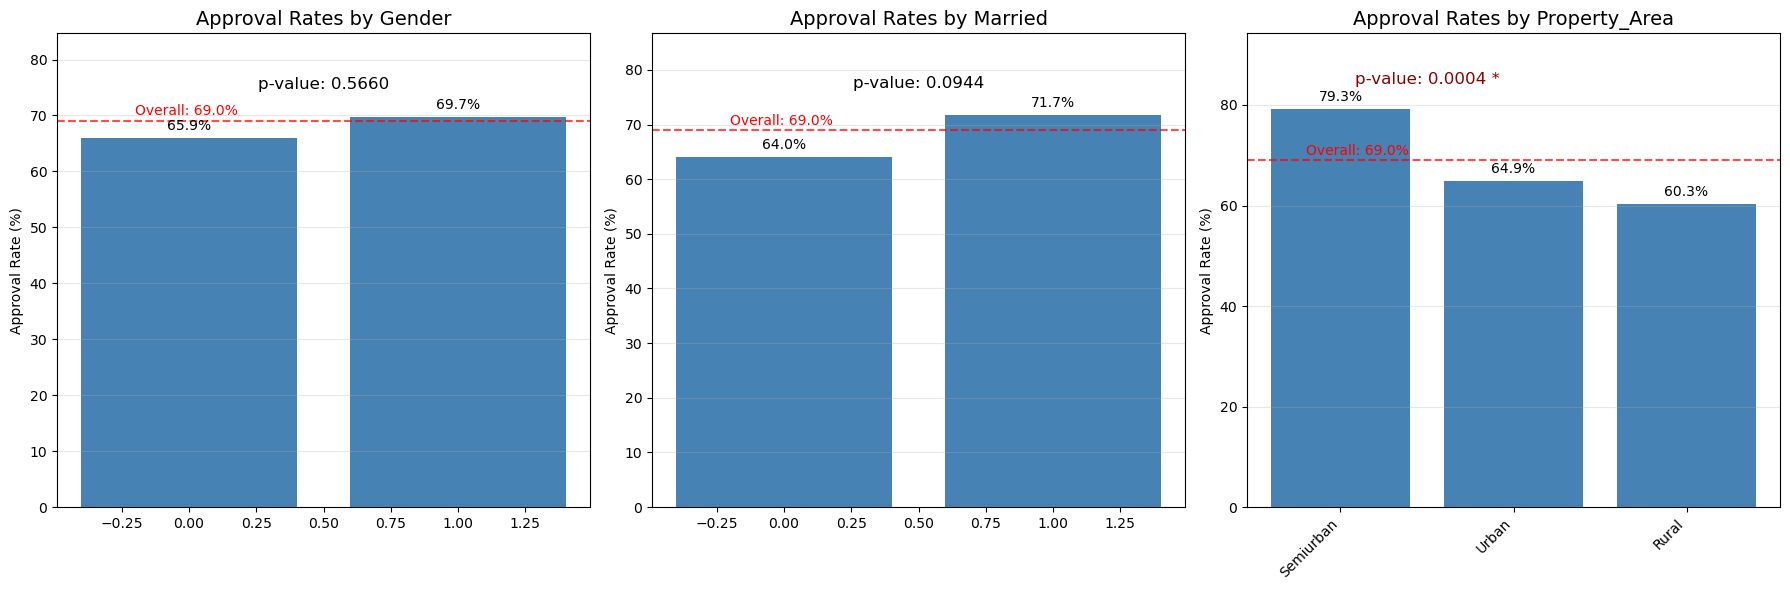

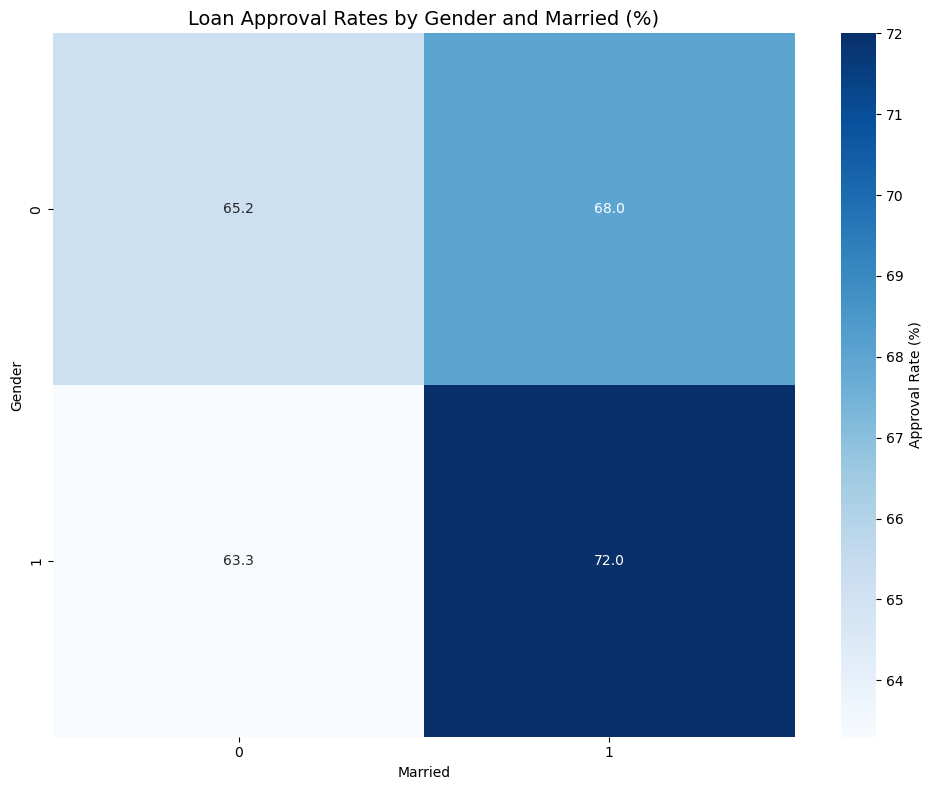


===== Intersectional Analysis =====

----- Intersectional Analysis: Gender × Married -----
===== Group-wise Approval Rate Analysis =====


----- Analysis for Gender_Married -----
Contingency Table for Gender_Married:
Loan_Status       0    1  All
Gender_Married               
0_0              23   43   66
0_1               8   17   25
1_0              40   69  109
1_1              84  216  300
All             155  345  500

Approval Rates by Gender_Married:
  0_0: 65.15%
  0_1: 68.00%
  1_0: 63.30%
  1_1: 72.00%

Chi-Square Test Results:
  Chi2 value: 3.3850
  p-value: 0.3360
  Conclusion: No statistically significant evidence of relationship between Gender_Married and loan approval (p >= 0.05)

Disparity Metrics:
  Approval Rate Disparity: 8.70 percentage points
  Disparity Ratio: 0.88
  This indicates a moderate disparity in approval rates

----- Intersectional Analysis: Gender × Property_Area -----
===== Group-wise Approval Rate Analysis =====


----- Analysis for Gender_Property_A

In [7]:
def analyze_approval_bias(df, sensitive_features):
    """
    Perform comprehensive bias analysis for loan approvals based on sensitive features.
    
    Parameters:
    df (pandas.DataFrame): Dataframe containing loan application data
    sensitive_features (list): List of sensitive attributes to analyze
    
    Returns:
    dict: Dictionary containing analysis results
    """
    results = {}
    
    # Make sure we're working with a copy to avoid modifying the original
    analysis_df = df.copy()
    
    # Ensure Loan_Status is properly formatted for analysis
    if 'Loan_Status' in analysis_df.columns:
        if analysis_df['Loan_Status'].dtype == 'object':
            # If Loan_Status is categorical (Y/N), convert to binary
            analysis_df['Loan_Status'] = analysis_df['Loan_Status'].map({'Y': 1, 'N': 0})
    
    print("===== Group-wise Approval Rate Analysis =====\n")
    
    for feature in sensitive_features:
        print(f"\n----- Analysis for {feature} -----")
        
        # Create contingency table
        contingency = pd.crosstab(
            index=analysis_df[feature],
            columns=analysis_df['Loan_Status'],
            margins=True
        )
        
        # Calculate approval rates
        approval_rates = {}
        for category in contingency.index[:-1]:  # Exclude the 'All' row
            approved = contingency.loc[category, 1] if 1 in contingency.columns else 0
            total = contingency.loc[category, 'All']
            rate = approved / total if total > 0 else 0
            approval_rates[category] = rate * 100  # Convert to percentage
        
        # Store results
        results[feature] = {
            'contingency_table': contingency,
            'approval_rates': approval_rates
        }
        
        # Chi-Square Test of Independence
        # Drop the margins for the statistical test
        chi2_table = contingency.iloc[:-1, :-1]
        chi2, p_value, dof, expected = chi2_contingency(chi2_table)
        
        results[feature]['chi2_test'] = {
            'chi2': chi2,
            'p_value': p_value,
            'dof': dof,
            'expected': expected
        }
        
        # Print results
        print(f"Contingency Table for {feature}:")
        print(contingency)
        print(f"\nApproval Rates by {feature}:")
        for category, rate in approval_rates.items():
            print(f"  {category}: {rate:.2f}%")
            
        print(f"\nChi-Square Test Results:")
        print(f"  Chi2 value: {chi2:.4f}")
        print(f"  p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print(f"  Conclusion: There is a statistically significant relationship between {feature} and loan approval (p < 0.05)")
        else:
            print(f"  Conclusion: No statistically significant evidence of relationship between {feature} and loan approval (p >= 0.05)")
        
        # Calculate disparity metrics
        if len(approval_rates) > 1:
            max_rate = max(approval_rates.values())
            min_rate = min(approval_rates.values())
            
            disparity_ratio = min_rate / max_rate if max_rate > 0 else 0
            disparity_diff = max_rate - min_rate
            
            results[feature]['disparity_metrics'] = {
                'disparity_ratio': disparity_ratio,
                'disparity_diff': disparity_diff
            }
            
            print(f"\nDisparity Metrics:")
            print(f"  Approval Rate Disparity: {disparity_diff:.2f} percentage points")
            print(f"  Disparity Ratio: {disparity_ratio:.2f}")
            
            if disparity_ratio < 0.8:
                print("  This indicates a substantial disparity in approval rates")
            elif disparity_ratio < 0.9:
                print("  This indicates a moderate disparity in approval rates")
            else:
                print("  This indicates a relatively small disparity in approval rates")
    
    return results

### Key Findings
- Property Area is the strongest predictor of approval disparities, with semiurban areas consistently favored.
- Gender alone doesn't show bias, but combined with property area reveals some female applicants (particularly in rural/urban areas) have lower approval rates.
- Marital status effects are moderate and become more pronounced when combined with property location.
- Substantial disparities exist at intersections:
- The unmarried urban applicants (all genders) face the lowest approval rates
- Semiurban applicants (especially married ones) enjoy the highest approval rates

**plot_approval_rates() Function**

Visualizes the approval rate disparities:

- Creates bar charts for each sensitive feature showing approval rates
- Adds reference lines for overall approval rate
- Marks statistically significant results (p-value < 0.05) with an asterisk
- Formats the charts for readability with data labels and proper scaling

In [9]:
def plot_approval_rates(results, sensitive_features):
    """
    Plot approval rates for sensitive features.
    
    Parameters:
    results (dict): Results from analyze_approval_bias function
    sensitive_features (list): List of sensitive attributes to plot
    """
    n_features = len(sensitive_features)
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(1, n_features, figsize=(6*n_features, 6))
    
    # If there's only one feature, axes won't be an array
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(sensitive_features):
        approval_rates = results[feature]['approval_rates']
        
        # Sort by approval rate for better visualization
        sorted_items = sorted(approval_rates.items(), key=lambda x: x[1], reverse=True)
        categories = [item[0] for item in sorted_items]
        rates = [item[1] for item in sorted_items]
        
        # Create bar chart
        bars = axes[i].bar(categories, rates, color='steelblue')
        
        # Add data labels on top of bars
        for bar in bars:
            height = bar.get_height()
            axes[i].text(
                bar.get_x() + bar.get_width()/2.,
                height + 1,
                f'{height:.1f}%',
                ha='center',
                va='bottom',
                fontsize=10
            )
        
        # Add reference line for overall approval rate
        contingency = results[feature]['contingency_table']
        overall_rate = (contingency.loc['All', 1] / contingency.loc['All', 'All']) * 100 if 1 in contingency.columns else 0
        axes[i].axhline(y=overall_rate, linestyle='--', color='red', alpha=0.7)
        axes[i].text(
            -0.2, 
            overall_rate + 1, 
            f'Overall: {overall_rate:.1f}%', 
            color='red'
        )
        
        # Calculate and add p-value to plot
        p_value = results[feature]['chi2_test']['p_value']
        p_value_text = f'p-value: {p_value:.4f}' + (' *' if p_value < 0.05 else '')
        axes[i].text(
            0.5, 
            max(rates) + 5,
            p_value_text,
            ha='center',
            fontsize=12,
            color='darkred' if p_value < 0.05 else 'black'
        )
        
        # Formatting
        axes[i].set_title(f'Approval Rates by {feature}', fontsize=14)
        axes[i].set_ylabel('Approval Rate (%)')
        axes[i].set_ylim(0, max(rates) + 15)
        axes[i].grid(axis='y', alpha=0.3)
        
        # Rotate x-axis labels if needed
        if max([len(str(cat)) for cat in categories]) > 5:
            axes[i].set_xticklabels(categories, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

**plot_approval_comparison_heatmap() Function**

Creates an intersectional analysis visualization:

- Shows approval rates across combinations of two features (e.g., Gender × Property_Area)
- Uses a heatmap with color intensity representing approval rates
- Includes numerical values in each cell

In [10]:
def plot_approval_comparison_heatmap(df, sensitive_features):
    """
    Create a heatmap showing intersectional approval rates across combinations of features.
    
    Parameters:
    df (pandas.DataFrame): Dataframe containing loan application data
    sensitive_features (list): List of sensitive attributes to analyze (limited to 2)
    """
    if len(sensitive_features) < 2:
        print("Need at least 2 features for comparison heatmap")
        return
    
    # Use first two features for the heatmap
    feature1, feature2 = sensitive_features[:2]
    
    # Create a pivot table for approval rates
    pivot_data = df.pivot_table(
        values='Loan_Status',
        index=feature1,
        columns=feature2,
        aggfunc='mean'  # Mean of binary outcome gives approval rate
    ) * 100  # Convert to percentage
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        pivot_data,
        annot=True,
        fmt='.1f',
        cmap='Blues',
        cbar_kws={'label': 'Approval Rate (%)'}
    )
    plt.title(f'Loan Approval Rates by {feature1} and {feature2} (%)', fontsize=14)
    plt.tight_layout()
    plt.show()

## Main Execution

- Defines the sensitive features to analyze (Gender, Married, Property_Area)
- Runs the analysis and creates visualizations
- Performs additional intersectional analysis for all pairs of features

===== Group-wise Approval Rate Analysis =====


----- Analysis for Gender -----
Contingency Table for Gender:
Loan_Status    0    1  All
Gender                    
0             31   60   91
1            124  285  409
All          155  345  500

Approval Rates by Gender:
  0: 65.93%
  1: 69.68%

Chi-Square Test Results:
  Chi2 value: 0.3294
  p-value: 0.5660
  Conclusion: No statistically significant evidence of relationship between Gender and loan approval (p >= 0.05)

Disparity Metrics:
  Approval Rate Disparity: 3.75 percentage points
  Disparity Ratio: 0.95
  This indicates a relatively small disparity in approval rates

----- Analysis for Married -----
Contingency Table for Married:
Loan_Status    0    1  All
Married                   
0             63  112  175
1             92  233  325
All          155  345  500

Approval Rates by Married:
  0: 64.00%
  1: 71.69%

Chi-Square Test Results:
  Chi2 value: 2.7973
  p-value: 0.0944
  Conclusion: No statistically significant evidence

C:\Users\milto\AppData\Local\Temp\ipykernel_432\1793137727.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(categories, rotation=45, ha='right')


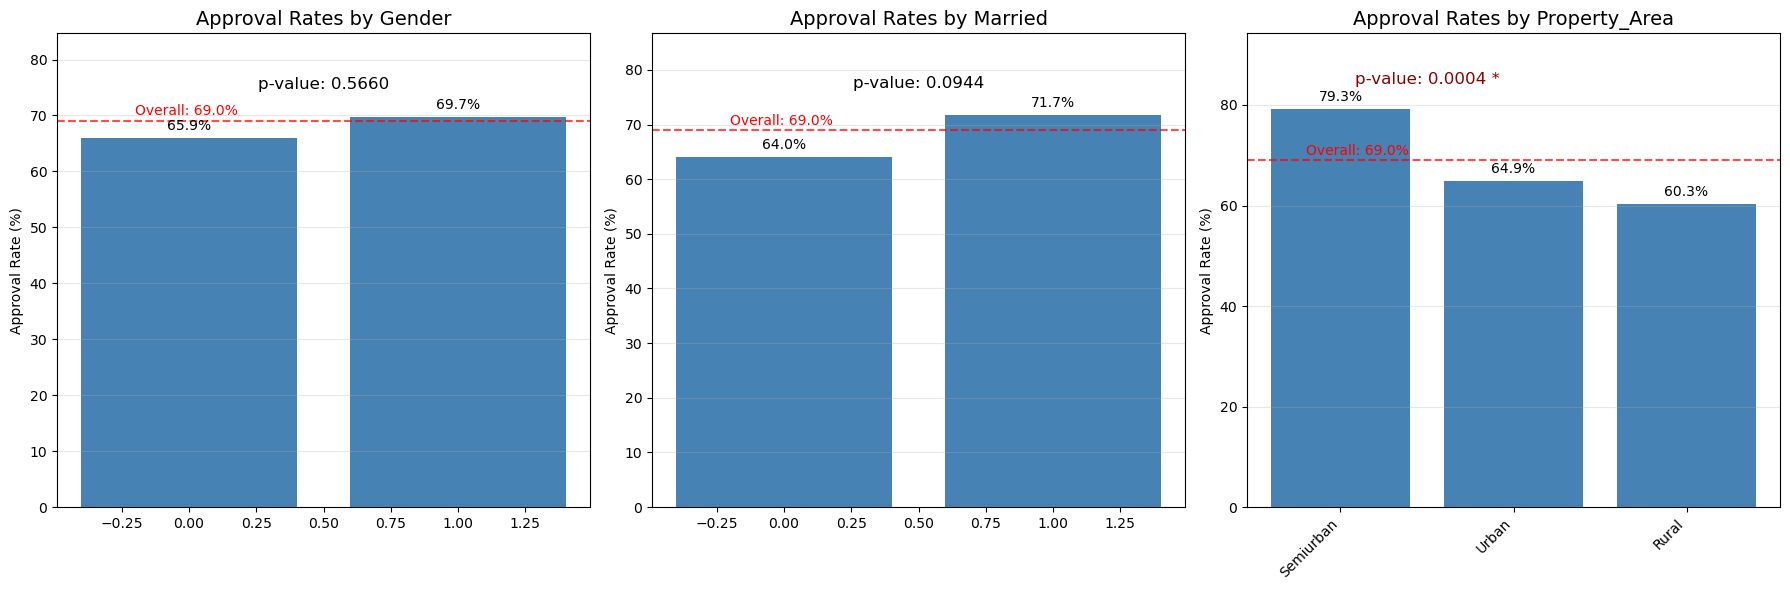

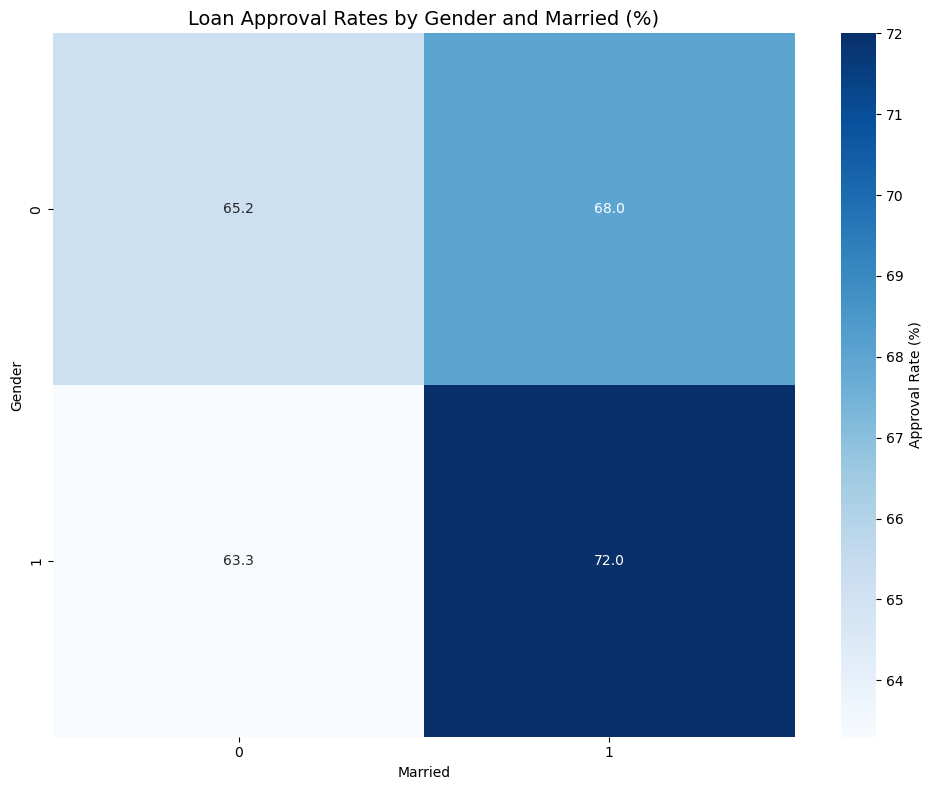


===== Intersectional Analysis =====

----- Intersectional Analysis: Gender × Married -----
===== Group-wise Approval Rate Analysis =====


----- Analysis for Gender_Married -----
Contingency Table for Gender_Married:
Loan_Status       0    1  All
Gender_Married               
0_0              23   43   66
0_1               8   17   25
1_0              40   69  109
1_1              84  216  300
All             155  345  500

Approval Rates by Gender_Married:
  0_0: 65.15%
  0_1: 68.00%
  1_0: 63.30%
  1_1: 72.00%

Chi-Square Test Results:
  Chi2 value: 3.3850
  p-value: 0.3360
  Conclusion: No statistically significant evidence of relationship between Gender_Married and loan approval (p >= 0.05)

Disparity Metrics:
  Approval Rate Disparity: 8.70 percentage points
  Disparity Ratio: 0.88
  This indicates a moderate disparity in approval rates

----- Intersectional Analysis: Gender × Property_Area -----
===== Group-wise Approval Rate Analysis =====


----- Analysis for Gender_Property_A

In [11]:
# Main execution
def main():
    # Use the global dataframe from your existing code
    # Alternatively, you can load your data here
    # df = pd.read_csv('your_loan_data.csv')
    
    # Define sensitive attributes to analyze
    sensitive_features = ['Gender', 'Married', 'Property_Area']
    
    # Run the analysis
    results = analyze_approval_bias(df, sensitive_features)
    
    # Create visualizations
    plot_approval_rates(results, sensitive_features)
    
    # Create intersectional heatmap
    plot_approval_comparison_heatmap(df, sensitive_features)
    
    # Additional intersectional analysis - create all possible pairs
    if len(sensitive_features) > 2:
        from itertools import combinations
        pairs = list(combinations(sensitive_features, 2))
        
        print("\n===== Intersectional Analysis =====")
        for pair in pairs:
            feature1, feature2 = pair
            print(f"\n----- Intersectional Analysis: {feature1} × {feature2} -----")
            
            # Create a combined feature
            df[f'{feature1}_{feature2}'] = df[feature1].astype(str) + "_" + df[feature2].astype(str)
            
            # Analyze the combined feature
            intersection_results = analyze_approval_bias(df, [f'{feature1}_{feature2}'])
            
            # Remove the temporary combined feature
            df.drop(columns=[f'{feature1}_{feature2}'], inplace=True)

if __name__ == "__main__":
    main()

### Key Patterns Emerging
- Semiurban Advantage: This location consistently shows higher approval rates regardless of other factors
- Compound Effects: While gender alone shows no bias, female applicants in rural/urban areas face lower approval rates
- Marital Status Matters More in Certain Areas: The marital status disparity is most pronounced in semiurban areas

## Conclusion

The analysis suggests that property area is the strongest predictor of loan approval disparities, with semiurban applicants significantly favored. While gender alone does not show bias, intersectional analysis reveals that women in rural/urban areas and single urban applicants face systemic disadvantages. These findings highlight the need for fair lending practices that ensure equitable access to credit across all demographic groups.

### Key Findings

1. No Significant Gender Bias Alone
- Approval rates for male (69.68%) and female (65.93%) applicants showed only a small, statistically insignificant difference (p=0.566).
- However, intersectional analysis revealed that women in rural and urban areas faced lower approval rates (~57%) compared to semiurban men (~80%), suggesting location compounds gender effects.

2. Marital Status Has Moderate Impact
- Married applicants (71.69%) were approved more often than singles (64.00%), though this difference was not statistically significant (p=0.094).
- When combined with property area, married semiurban applicants had the highest approval rate (81.75%), while single urban applicants had the lowest (56.67%).

3. Strong Evidence of Location-Based Bias
- Semiurban applicants (79.26%) were significantly more likely to be approved than rural (60.28%) and urban (64.91%) applicants (p=0.0004).
- This disparity persisted in intersectional analysis, with semiurban applicants consistently favored regardless of gender or marital status.

4. Intersectional Disparities Are Most Severe
- The largest gaps appeared when combining factors:
- Married semiurban applicants (81.75%) vs. single urban applicants (56.67%)—a 25-percentage-point gap.
- Female rural/urban applicants (~57%) vs. male semiurban applicants (~80%)—a 23-percentage-point gap.

### Recommendations

1. Investigate Semiurban Bias: Determine whether higher approval rates in semiurban areas are justified by stronger applicant qualifications or reflect systemic bias.

2. Review Urban/Rural Discrepancies: Applicants from these areas face significantly lower approval rates—consider whether risk assessment models unfairly disadvantage them.

3. Monitor Intersectional Effects: While gender alone doesn’t show bias, women in certain locations face compounded disadvantages.

4. Improve Transparency: Ensure loan approval criteria are clearly defined and applied consistently across demographics.

5. Further Analysis: Incorporate financial factors (income, credit score, loan amount) to assess whether disparities persist after controlling for risk.